# Brain Tumor Detection with Machine Learning

## By: Tyler David

## Import Libraries

In [1]:
import numpy as np
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.ndimage import convolve
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import warnings

c:\Users\tydav\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\tydav\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\tydav\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
c:\Users\tydav\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disab

## Read in Data

In the dataset, we have MRI scan images that are all of different size, ranging from a size of $1302\times 1335\times 3$ pixels to $200\times 200\times 3$ pixels. To keep the image size consistent, we resize the images to the median of $1302\times 1335\times 3$ and $200\times 200\times 3$, which is $751\times 768\times 3$ pixels. Scikit-image's resize function is used to resize the MRI scan images to $200\times 200\times 3$.

Deep learning requires a lot of memory to run in Python. To alleviate this issue, the MRI images are converted to grayscale so that there is only one channel of the images instead of the 3 channels associated with RGB images. Hence, the MRI images now consist of $200\times 200$ pixels. The RGB images are converted to grayscale images using the following transformation for color channels $R, G, B\in\mathbb{R}^{200\times 200}$
$$Grayscale = 0.299R + 0.587G + 0.144B.$$

In [2]:
def read_images(directory):
    '''
    This function takes in a string representing the base directory of the .jpg image files.
    We use this function to iterate through the folders of MRI images, convert them into grayscale,
    and separate them by tumor type (if any). This function returns the dictionary of images.

    Args:
        directory: a string representing the base directory that contains the grayscale MRI images.
    
    Returns:
        a dictionary of images separated by class.
    '''
    # separate into train and test images
    train_test = ["Training", "Testing"]
    images = {"glioma_tumor": [], "meningioma_tumor": [], "pituitary_tumor": [], "no_tumor": []}
    
    # iterate through folders to store images
    for key in images.keys():
        for t in train_test:
            folder_pattern = os.path.join(directory, t, key)
            image_paths = glob.glob(f"{folder_pattern}/*")
            # store each image in list for each class
            for im in image_paths:
                # read in image
                image = Image.open(im)

                # convert RGB image to grayscale image
                image_gray = np.asarray(image.convert("L"))
                # add grayscale image to dictionary
                images[key].append(resize(image_gray, (200, 200)))
    
    return images


In [3]:
images = read_images("../MRI_Scan_Project/Data")

In [4]:
def flatten_images(image_dict):
    '''
    This function takes in a dictionary of the .jpg MRI images. We use this function to
    iterate through each class of the dictionary and within each class, flatten each MRI
    image. This function returns the dictionary of flattened images.

    Args:
        image_dict: a dictionary of MRI images.
    
    Returns:
        a dictionary of flattened images separated by class.
    '''
    # initialize dictionary of flattened images
    flattened_images = dict()

    for key in image_dict.keys():
        # initialize list of images for each class
        flattened_images[key] = list()
        for i in range(len(image_dict[key])):
            im_dims = image_dict[key][i].shape
            flattened_images[key].append(image_dict[key][i].reshape((1, im_dims[0]*im_dims[1])))
    
    return flattened_images

In [5]:
# flatten images
flat_images_by_class = flatten_images(images)
flat_images = np.array([ims for key in flat_images_by_class.keys() for ims in flat_images_by_class[key]]).reshape((3264, 200**2))
labels = np.array([key for key in flat_images_by_class.keys() for i in range(len(flat_images_by_class[key]))]).reshape((3264, 1))

# unique labels
labels_unique = ["glioma_tumor", "meningioma_tumor", "pituitary_tumor", "no_tumor"]

# mapping from string to integer labels
label_to_int = {label: index for index, label in enumerate(labels_unique)}
int_to_label = {val: key for key, val in label_to_int.items()}

# convert to integer labels
labels_int = np.array([label_to_int[label] for label in labels.flatten()])



In [6]:
num_ims_by_class = {key: len(val) for key, val in flat_images_by_class.items()}

print("Number of Images by Class:")
for key, val in num_ims_by_class.items():
    print(f"{key}: {val}")

Number of Images by Class:
glioma_tumor: 926
meningioma_tumor: 937
pituitary_tumor: 901
no_tumor: 500


## Visualize 2D Representaion of Images with PCA

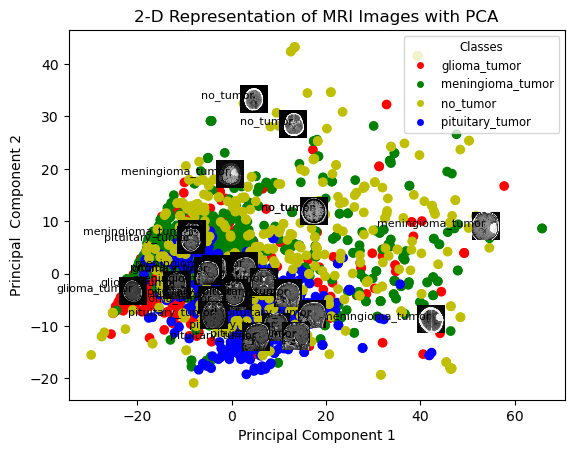

In [7]:
np.random.seed(1) # for reproducibility

# scale images
flat_images_scaled = flat_images/np.max(flat_images)

# initialize PCA
two_dim_ims = PCA(n_components=2).fit_transform(flat_images_scaled)

# define colormap for classes
colors = ["r", "g", "b", "y"]  # red, green, blue, yellow
class_colors = [colors[label] for label in labels_int]  # map class labels to colors

# 2D scatter plot
fig, ax = plt.subplots() # initialize scatter plot
plt.scatter(two_dim_ims[:, 0].T, two_dim_ims[:, 1].T, c=class_colors)
plt.title("2-D Representation of MRI Images with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal  Component 2")

# add images to graph
for i in np.random.randint(0, 3264, size = 25):
    im = flat_images[i].reshape((200, 200))
    imagebox = OffsetImage(im, zoom=0.1, cmap="gray")
    ab = AnnotationBbox(imagebox, two_dim_ims[i], frameon=False)
    ax.add_artist(ab)
    ax.text(two_dim_ims[i, 0], two_dim_ims[i, 1], labels[i, 0], fontsize=8, ha="right")

# add legend
legend_labels = np.unique(labels)
handles = [plt.Line2D([0], [0], marker="o", color="w", label=f"{label}",
                      markerfacecolor=colors[label_to_int[label]], markersize=6) for label in legend_labels]
ax.legend(handles=handles, title="Classes", fontsize="small", title_fontsize="small")

plt.show()


Using principal component analysis, I transformed each image into its 2-dimensional representation to view any patterns within the MRI image data. As seen in the plot of the 2-dimensional representation of the data points above, there are not very clear distinctions between classes of tumors. MRI images containing a pituitary tumor however forms a dense cluster. The MRI images that do not contain a tumor appear to be the most scattered across the graph.

## Scree Plot for Image Compression with PCA

The number of principal components used to compress the MRI images is determined by a scree plot, which is a plot of the proportion of the variance explained by the number of principal components used.

Traditionally, the number of principal components used is at the "elbow" of the scree plot. But the resulting compressed images were not a reasonable representation of a low-resolution version of the MRI images. Hence, I used the first 500 principal components to construct the low-resolution MRI images.

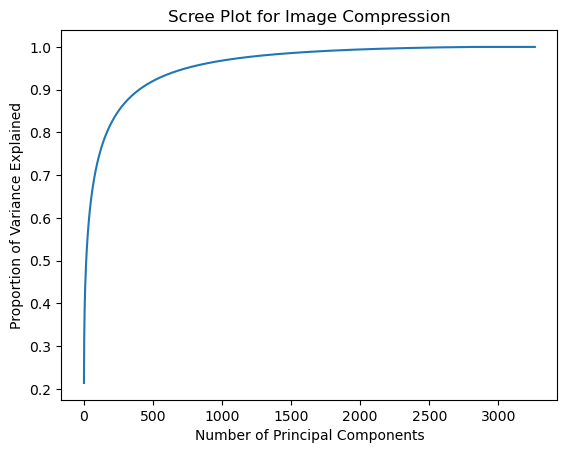

In [8]:
# initialize PCA
pca = PCA()

# fit PCA
pca.fit(flat_images_scaled)

# proportion of variance explained using each additional principal component
prop_explained_var = pca.explained_variance_ratio_

# scree plot
plt.plot(range(1, len(prop_explained_var) + 1), prop_explained_var.cumsum())
plt.title("Scree Plot for Image Compression")
plt.xlabel("Number of Principal Components")
plt.ylabel("Proportion of Variance Explained")

plt.show()

## Image Compression 

Principal component analysis (PCA) is used to compress the MRI images, which lowers the image resolution. Suppose we take a matrix of image vectors $I\in\mathbb{R}^{m\times n}.$ Its covariance matrix $C\in\mathbb{R}^{m\times m}$ is found by $C=II^T$. Then we solve the eigenvalue problem $Cu = \lambda u$ for each eigenvector $u\in\mathbb{R}^m$ and its associated eigenvalue $\lambda\in\mathbb{R},$ which leads us to the eigendecomposition 

$$C = U\Lambda U^T = \begin{pmatrix} u_1 & \ldots & u_m \end{pmatrix}\begin{pmatrix} \lambda_1 & 0 & \ldots & 0 \\ 0 & \lambda_2 & \ldots & 0 \\ \vdots & \vdots & \ddots & \vdots  \\ 0 & 0 & \ldots & \lambda_m \end{pmatrix}\begin{pmatrix} u_1 & \ldots & u_m \end{pmatrix}^T.$$

$U\in\mathbb{R}^{m\times m}$ is a matrix of the eigenvectors of the covariance matrix. $\Lambda\in\mathbb{R}^{m\times m}$ is a diagonal matrix of the associated eigenvalues of each eigenvector, which ranks the proportion of data (variance) preserved by each principal component; that is, the eigenvector $u_1$ associated with eigenvalue $\lambda_1$ preserves the largest amount of data.

Now suppose $U^{*}\in\mathbb{R}^{m\times 500}$ is the matrix of the first 500 eigenvectors $u$, and recall $I\in\mathbb{R}^{m\times n}$ is the matrix of image vectors. The matrix of image vectors in the reduced space is found by $(U^{*})^{T}I$, and the matrix of compressed image vectors expressed in the original space $I^{*}$ is as follows
$$I^{*} = \begin{pmatrix}u_1 & \ldots & u_{500}\end{pmatrix}\begin{pmatrix} u_1 & \ldots & u_{500}\end{pmatrix}^T I = U^{*}(U^{*})^TI\in\mathbb{R}^{m\times n}.$$

In [9]:
def compress_flat_images(flat_images, n):
    '''
    This function takes in a numpy array of row MRI image vectors. It is used to compress the image 
    vectors into their n-dimensional representations (while maintaining the same 4000 pixel structure).
    This function returns a numpy array of the compressed MRI image vectors.

    Args:
        flat_images: a numpy array of MRI image row vectors.
        n: the desired number of dimensions to compress the MRI images to.
    
    Returns:
        a numpy array of the flat and compressed MRI images.
    '''
    # initialize PCA
    pca = PCA(n_components=n)

    # PCA
    principal_comps = pca.fit_transform(flat_images)

    # compressed images
    compressed_images = pca.inverse_transform(principal_comps)

    return compressed_images
    


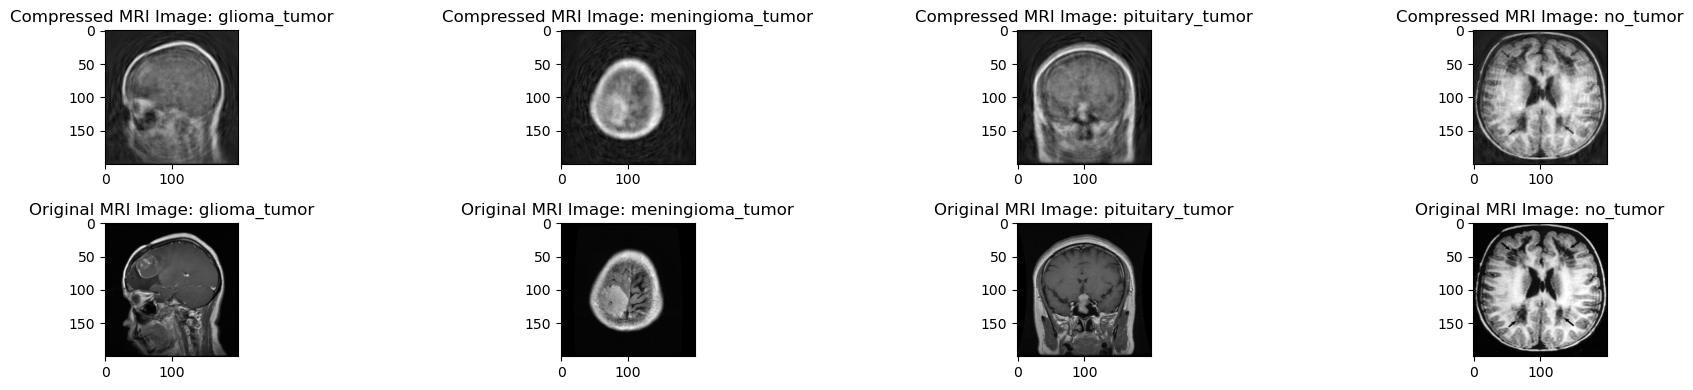

In [10]:
# initialize row of images
fig, ax = plt.subplots(2, 4, figsize=(20, 4))

# random indices of images in each class
inds = [27, 1034, 2024, 3012]
classes = list(flat_images_by_class.keys())

# compressed images
compressed_ims = compress_flat_images(flat_images_scaled, 500)

for i in range(len(inds)):
    # add compressed image to matrix
    ax[0, i].set_title(f"Compressed MRI Image: {classes[i]}")
    ax[0, i].imshow(compressed_ims[inds[i]].reshape(200, 200), cmap="gray")

    # add original image to matrix
    ax[1, i].set_title(f"Original MRI Image: {classes[i]}")
    ax[1, i].imshow(flat_images[inds[i]].reshape((200, 200)), cmap="gray")

plt.tight_layout()
plt.show()

# Brain Tumor Classification of Compressed Images

## Train/Test Split

In [11]:
np.random.seed(1) # for reproducibility

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(flat_images_scaled.reshape((-1, 200, 200)), labels, test_size=0.2, shuffle=True)


In [12]:
np.random.seed(1) # for reproducibility

# 10-fold cross validation
cv = KFold(n_splits=10, shuffle=True)

# normalize train and test data
X_train_norm = X_train/np.max(X_train)
X_test_norm = X_test/np.max(X_test)


In [13]:
# list of unique labels
unique_labels = ["glioma_tumor", "meningioma_tumor", "pituitary_tumor", "no_tumor"]

# Create a mapping from string labels to integers
label_to_int = {label: index for index, label in enumerate(unique_labels)}
int_to_label = {val: key for key, val in label_to_int.items()}

print(label_to_int)
print(int_to_label)

# Convert y_train and y_test to integer labels
y_train_int = np.array([label_to_int[label] for label in y_train.flatten()])
y_test_int = np.array([label_to_int[label] for label in y_test.flatten()])


{'glioma_tumor': 0, 'meningioma_tumor': 1, 'pituitary_tumor': 2, 'no_tumor': 3}
{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'pituitary_tumor', 3: 'no_tumor'}


In [14]:
# since images are grayscale, use unsqueeze to convert to tensor
X_train_torch = torch.tensor(X_train_norm, dtype=torch.float32).unsqueeze(1)
y_train_torch = torch.tensor(y_train_int, dtype=torch.long)
X_test_torch = torch.tensor(X_test_norm, dtype=torch.float32).unsqueeze(1)
y_test_torch = torch.tensor(y_test_int, dtype=torch.long)

# create datasets
train_ims = TensorDataset(X_train_torch, y_train_torch)
test_ims = TensorDataset(X_test_torch, y_test_torch)

# data loader to use small batch size for image tensors
train_loader = DataLoader(train_ims, batch_size=10, shuffle=True)
test_loader = DataLoader(test_ims, batch_size=10, shuffle=False)

## Convolutional Neural Network

In [15]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)

        # fully connected layer
        self.fc1 = nn.Linear(48*48*16, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2) # 2x2 kernel with stride 2
        
        # second pass
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2) # 2x2 kernel with stride 2

        # Re-view to flatten out
        X = X.view(-1, 16*48*48)

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)

        return F.log_softmax(X, dim=1)

In [16]:
torch.manual_seed(1) # for reproducibility

# loss function optimizer
cnn = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

## Convolutional Neural Network

In [17]:
torch.manual_seed(1)

# variables to track things
epochs = 10
train_losses = list()
test_losses = list()
train_correct = list()
test_correct = list()

# for loop
for i in range(epochs):
    train_cor = 0
    test_cor = 0

    # train
    for b, (X_train_b, y_train_b) in enumerate(train_loader):
        b += 1 # start batches at 1
        y_pred = cnn(X_train_b) # not flattened for 1st convolutional layer
        loss = criterion(y_pred, y_train_b) # error

        # sum correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_cor = (predicted == y_train_b).sum()
        train_cor += batch_cor

        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%60 == 0:
            print(f"Epoch: {i+1}, Batch: {b}, Loss: {loss.item()}")

    train_losses.append(loss.detach().numpy())
    train_correct.append(train_cor.detach().numpy())

    # validation
    with torch.no_grad():
        for b, (X_test_b, y_test_b) in enumerate(test_loader):
            y_val = cnn(X_test_b)
            predicted = torch.max(y_pred.data, 1)[1] # sum correct predictions
            test_cor += (predicted == y_test_b).sum()
            loss = criterion(y_val, y_test_b)
            
    test_losses.append(loss.detach().numpy())
    test_correct.append(test_cor.detach().numpy())


Epoch: 1, Batch: 60, Loss: 1.3175245523452759
Epoch: 1, Batch: 120, Loss: 1.2349045276641846
Epoch: 1, Batch: 180, Loss: 1.0413508415222168
Epoch: 1, Batch: 240, Loss: 0.9434576034545898
Epoch: 2, Batch: 60, Loss: 0.7057018876075745
Epoch: 2, Batch: 120, Loss: 0.6577929258346558
Epoch: 2, Batch: 180, Loss: 0.7145718336105347
Epoch: 2, Batch: 240, Loss: 0.5021535754203796
Epoch: 3, Batch: 60, Loss: 0.46368712186813354
Epoch: 3, Batch: 120, Loss: 0.8557555079460144
Epoch: 3, Batch: 180, Loss: 0.27038073539733887
Epoch: 3, Batch: 240, Loss: 0.7497100234031677
Epoch: 4, Batch: 60, Loss: 0.08956922590732574
Epoch: 4, Batch: 120, Loss: 0.3045724332332611
Epoch: 4, Batch: 180, Loss: 0.16593709588050842
Epoch: 4, Batch: 240, Loss: 0.1497080773115158
Epoch: 5, Batch: 60, Loss: 0.2194816619157791
Epoch: 5, Batch: 120, Loss: 0.09512177854776382
Epoch: 5, Batch: 180, Loss: 0.25204259157180786
Epoch: 5, Batch: 240, Loss: 0.5129844546318054
Epoch: 6, Batch: 60, Loss: 0.02192508615553379
Epoch: 6, Ba

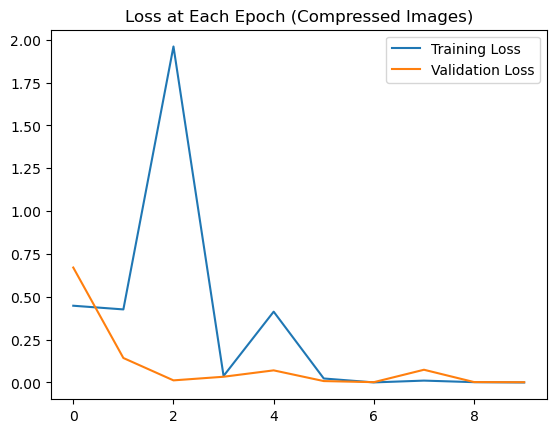

In [18]:
# plot of train and validation losses of CNN
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Each Epoch (Compressed Images)")
plt.legend()
plt.show()

In [19]:
test_all = DataLoader(test_ims, batch_size=653, shuffle=False)

In [20]:
# CNN testing
with torch.no_grad():
    correct = 0
    for (X_test_all, y_test_all) in test_all:
        y_val = cnn(X_test_all)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test_all).sum()
        

In [21]:
# accuracy, precision, recall, F1 scores
print(f"CNN Model (Compressed Images)\n{classification_report(y_test_int, predicted.tolist(), target_names=unique_labels)}")

CNN Model (Compressed Images)
                  precision    recall  f1-score   support

    glioma_tumor       0.87      0.96      0.91       192
meningioma_tumor       0.93      0.81      0.87       195
 pituitary_tumor       0.93      0.98      0.96       172
        no_tumor       0.87      0.83      0.85        94

        accuracy                           0.90       653
       macro avg       0.90      0.90      0.90       653
    weighted avg       0.90      0.90      0.90       653



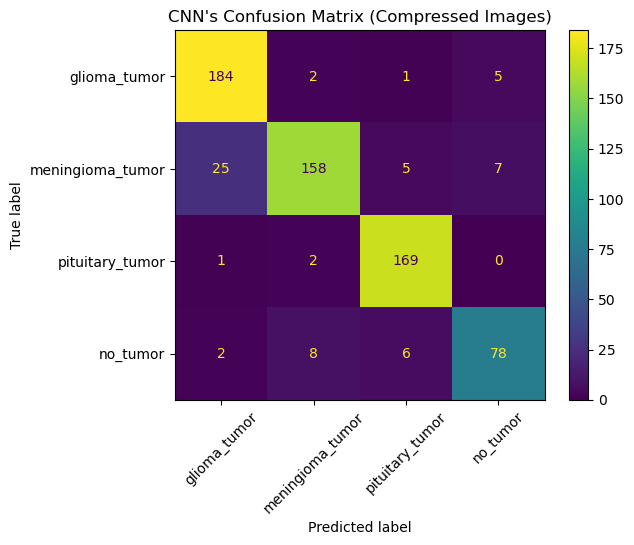

In [22]:
c_matrix = confusion_matrix(y_test_int, predicted.tolist(), labels=list(set(y_test_int)))
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=[int_to_label[integer] for integer in list(set(y_test_int))])

disp.plot()
disp.ax_.set(title="CNN's Confusion Matrix (Compressed Images)")
plt.xticks(rotation=45)  # rotate x-axis labels

plt.show()

## k-Nearest Neighbors Model

In [23]:
np.random.seed(1) # for reproducibility

# KNN grid search
knn_params = {"n_neighbors": range(3, 30, 2)}
knn_grid_search = GridSearchCV(KNeighborsClassifier(weights="distance"), param_grid=knn_params, cv=cv).fit(X_train_norm.reshape(-1, 200**2), y_train_int)
print(f"Optimal hyperparameters for KNN: {knn_grid_search.best_params_}\n")

# fit KNN model
knn = KNeighborsClassifier(**knn_grid_search.best_params_, weights="distance").fit(X_train_norm.reshape(-1, 200**2), y_train_int)

Optimal hyperparameters for KNN: {'n_neighbors': 3}



In [24]:
# KNN predictions
knn_predictions = knn.predict(X_test_norm.reshape(-1, 200**2))

# accuracy, precision, recall, F1 scores
print(f"KNN Model (Compressed Images)\n{classification_report(y_test_int, knn_predictions, target_names=unique_labels)}")

KNN Model (Compressed Images)
                  precision    recall  f1-score   support

    glioma_tumor       0.83      0.91      0.87       192
meningioma_tumor       0.90      0.78      0.84       195
 pituitary_tumor       0.89      0.99      0.94       172
        no_tumor       0.82      0.73      0.78        94

        accuracy                           0.87       653
       macro avg       0.86      0.85      0.85       653
    weighted avg       0.87      0.87      0.86       653



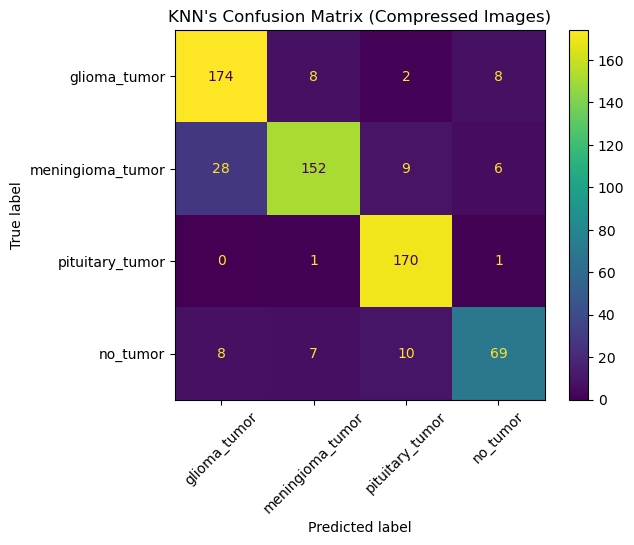

In [25]:
c_matrix = confusion_matrix(y_test_int, knn_predictions, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=[int_to_label[integer] for integer in knn.classes_])

disp.plot()
disp.ax_.set(title="KNN's Confusion Matrix (Compressed Images)")
plt.xticks(rotation=45)  # rotate x-axis labels

plt.show()

## Random Forest Model

In [26]:
np.random.seed(1) # for reproducibility

# fit random forest model
rforest = RandomForestClassifier(n_estimators=300, warm_start=True).fit(X_train_norm.reshape(-1, 200**2), y_train_int)


In [27]:
# random forest predictions
rforest_predictions = rforest.predict(X_test_norm.reshape(-1, 200**2))

# accuracy, precision, recall, F1 scores
print(f"Random Forest Model (Compressed Images)\n{classification_report(y_test_int, rforest_predictions, target_names=unique_labels)}")

Random Forest Model (Compressed Images)
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.88      0.93       192
meningioma_tumor       0.88      0.90      0.89       195
 pituitary_tumor       0.93      0.99      0.96       172
        no_tumor       0.85      0.91      0.88        94

        accuracy                           0.92       653
       macro avg       0.91      0.92      0.92       653
    weighted avg       0.92      0.92      0.92       653



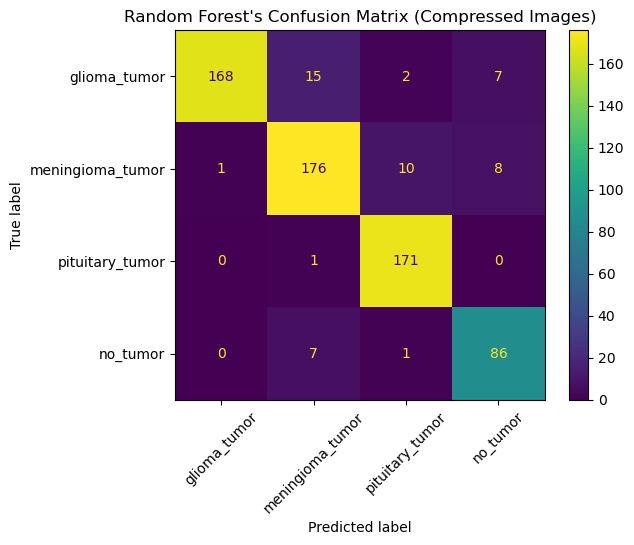

In [28]:
c_matrix = confusion_matrix(y_test_int, rforest_predictions, labels=rforest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=[int_to_label[integer] for integer in rforest.classes_])

disp.plot()
disp.ax_.set(title="Random Forest's Confusion Matrix (Compressed Images)")
plt.xticks(rotation=45)  # rotate x-axis labels

plt.show()

## Support Vector Machine Model

In [29]:
np.random.seed(1) # for reproducibility

# fit SVM model
svm = SVC(kernel="poly", decision_function_shape="ovo").fit(X_train_norm.reshape(-1, 200**2), y_train_int)


In [30]:
# SVM predictions
svm_predictions = svm.predict(X_test_norm.reshape(-1, 200**2))

# accuracy, precision, recall, F1 scores
print(f"SVM Model (Compressed Images)\n{classification_report(y_test_int, svm_predictions, target_names=unique_labels)}")


SVM Model (Compressed Images)
                  precision    recall  f1-score   support

    glioma_tumor       0.77      0.92      0.84       192
meningioma_tumor       0.86      0.70      0.77       195
 pituitary_tumor       0.87      0.99      0.93       172
        no_tumor       0.93      0.70      0.80        94

        accuracy                           0.84       653
       macro avg       0.86      0.83      0.83       653
    weighted avg       0.85      0.84      0.84       653



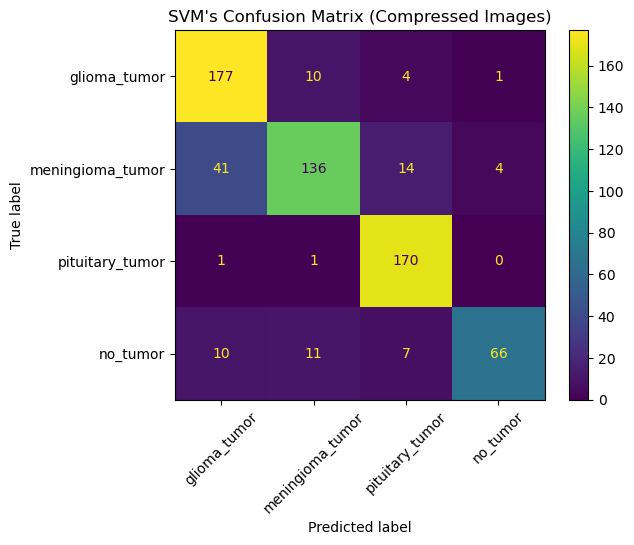

In [31]:
c_matrix = confusion_matrix(y_test_int, svm_predictions, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=[int_to_label[integer] for integer in svm.classes_])

disp.plot()
disp.ax_.set(title="SVM's Confusion Matrix (Compressed Images)")
plt.xticks(rotation=45)  # rotate x-axis labels

plt.show()

## Logistic Regression Model

In [32]:
np.random.seed(1) # for reproducibility

# ignore warnings
warnings.filterwarnings("ignore")

# fit logistic regression model
lreg = LogisticRegression(multi_class="multinomial").fit(X_train_norm.reshape(-1, 200**2), y_train_int)

In [33]:
# logistic regression predictions
lreg_predictions = lreg.predict(X_test_norm.reshape(-1, 200**2))

# accuracy, precision, recall, F1 scores
print(f"Logistic Regression Model (Compressed Images)\n{classification_report(y_test_int, lreg_predictions, target_names=unique_labels)}")

Logistic Regression Model (Compressed Images)
                  precision    recall  f1-score   support

    glioma_tumor       0.72      0.75      0.73       192
meningioma_tumor       0.75      0.69      0.72       195
 pituitary_tumor       0.88      0.97      0.93       172
        no_tumor       0.76      0.68      0.72        94

        accuracy                           0.78       653
       macro avg       0.78      0.77      0.77       653
    weighted avg       0.78      0.78      0.78       653



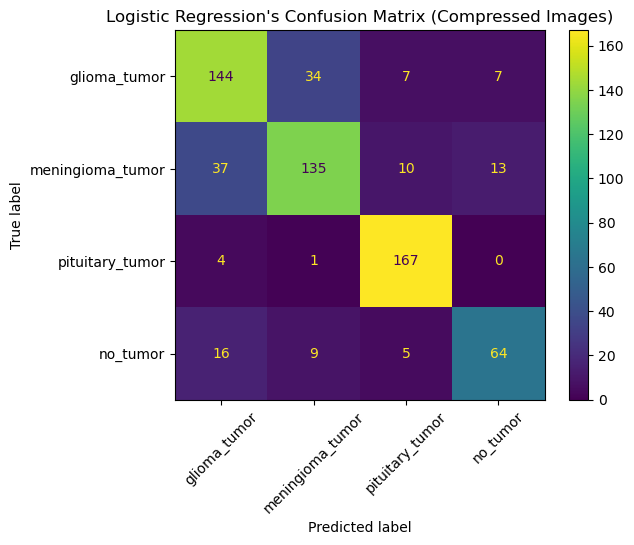

In [34]:
c_matrix = confusion_matrix(y_test_int, lreg_predictions, labels=lreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=[int_to_label[integer] for integer in lreg.classes_])

disp.plot()
disp.ax_.set(title="Logistic Regression's Confusion Matrix (Compressed Images)")
# Rotate the x and y labels
plt.xticks(rotation=45)  # Rotate x-axis labels

plt.show()

## Model Evaluation (Compressed Images)

This summary of evaluation metrics of each of the models is based on the macro average of precision, recall, and f1 score. Using the macro average makes each class of images weighted equally, since the goal is to decrease the bias towards the most frequent class.

| Model | Accuracy | Precision | Sensitivity/Recall | F1 Score |
| :-: | :-: | :-: | :-: | :-: |
| Convolutional Neural Network | 0.90 | 0.90 | 0.90 | 0.90 |
| k-Nearest Neighbors | 0.87 | 0.86 | 0.85 | 0.85 |
| Random Forest | 0.92 | 0.91 | 0.92 | 0.92 |
| Support Vector Machine | 0.84 | 0.86 | 0.83 | 0.83 |
| Logistic Regression | 0.78 | 0.78 | 0.77 | 0.77 |

Random Forest overall performs the best in terms of all four metrics. The precision, recall, and F1 score are nearly identical, which shows no bias towards predicting the most common class from the training data. Also, the convolutional neural network performs closely to as good as the random forest model with a score of 0.9 for accuracy, precision, recall, and F1 score, which also shows no bias towards predicting the most common class. In fact, none of the classification models show bias towards the most common class since precision, recall, and F1 score are nearly identical for each model.

Logistic regression performs the worst in all metrics. Considering that this is a multi-class classification problem, the logistic regression model's performance is still not terrible.

The convolutional neural network has the lowest chance of missing a tumor with a probability of $\frac{12}{90} = 13.33\%$. This is unfortunately still a little high for such a serious issue, so a radiologist would be advised to look further into an MRI scan if the CNN model does not detect a tumor.


# MRI Image Edge Detection

## Edge Detection with Sobel Operator

The Sobel operator in the x and y directions are defined as follows

$$M_x = \frac{1}{8}\begin{pmatrix} -1 & 0 & 1\\ -1 & 0 & 2\\ -1 & 0 & 1\end{pmatrix} \hspace{1cm} M_y = \frac{1}{8}\begin{pmatrix} -1 & -2 & -1\\ 0 & 0 & 0\\ 1 & 2 & 1 \end{pmatrix}.$$

We perform edge detection by convolution of each image $I$ and the Sobel operator: $f_x = M_x*I$ and $f_y = M_y*I$.

In [35]:
# first partial derivatives
sobel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])/8
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])/8

sobel_ims = list()

# convolution with Sobel operator
for im in compressed_ims:
    # convolution
    sobel_x_conv = convolve(im.reshape((200, 200)), sobel_x, mode="constant", cval=0)
    sobel_y_conv = convolve(im.reshape((200, 200)), sobel_y, mode="constant", cval=0)

    # compute f
    sobel_f = np.sqrt(sobel_x_conv**2 + sobel_y_conv**2)

    # normalize f to 0 to 255
    sobel_f_norm = np.uint8((255*sobel_f)/sobel_f.max())

    # use threshold of 40 for edge detection
    sobel_ims.append(cv2.threshold(sobel_f_norm, 40, 255, cv2.THRESH_BINARY)[1])

# standardize images
sobel_ims = np.array(sobel_ims)/np.max(sobel_ims)


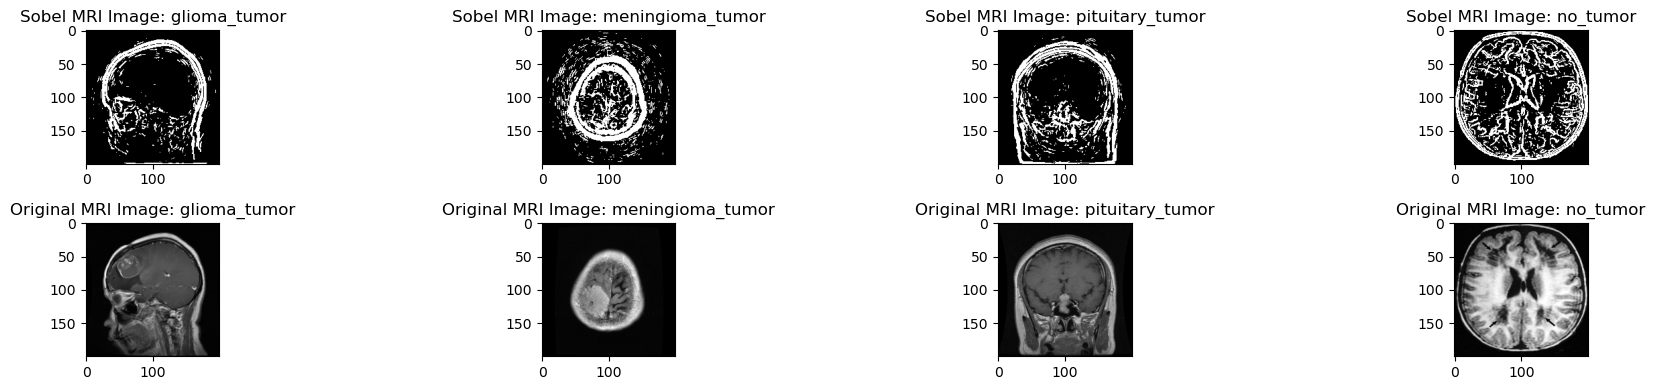

In [36]:
# initialize row of images
fig, ax = plt.subplots(2, 4, figsize=(20, 4))

# random indices of images in each class
inds = [27, 1034, 2024, 3012]
classes = list(flat_images_by_class.keys())

for i in range(len(inds)):
    # add compressed image to matrix
    ax[0, i].set_title(f"Sobel MRI Image: {classes[i]}")
    ax[0, i].imshow(sobel_ims[inds[i]], cmap="gray")

    # add original image to matrix
    ax[1, i].set_title(f"Original MRI Image: {classes[i]}")
    ax[1, i].imshow(flat_images[inds[i]].reshape((200, 200)), cmap="gray")

plt.tight_layout()
plt.show()

# Brain Tumor Classification After Edge Detection of the Compressed Images

## Train/Test Split

In [37]:
np.random.seed(1) # for reproducibility

# 80/20 train/test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(sobel_ims.reshape((-1, 200, 200)), labels, test_size=0.2, shuffle=True)


In [38]:
np.random.seed(1) # for reproducibility

# 10-fold cross validation
cv = KFold(n_splits=10, shuffle=True)


In [39]:
# list of unique labels
unique_labels = ["glioma_tumor", "meningioma_tumor", "pituitary_tumor", "no_tumor"]

# Create a mapping from string labels to integers
label_to_int = {label: index for index, label in enumerate(unique_labels)}
int_to_label = {val: key for key, val in label_to_int.items()}
print(label_to_int)
print(int_to_label)

# Convert y_train and y_test to integer labels
y_train_int2 = np.array([label_to_int[label] for label in y_train2.flatten()])
y_test_int2 = np.array([label_to_int[label] for label in y_test2.flatten()])


{'glioma_tumor': 0, 'meningioma_tumor': 1, 'pituitary_tumor': 2, 'no_tumor': 3}
{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'pituitary_tumor', 3: 'no_tumor'}


In [40]:
# since images are grayscale, use unsqueeze to convert to tensor
X_train_torch = torch.tensor(X_train2, dtype=torch.float32).unsqueeze(1)
y_train_torch = torch.tensor(y_train_int2, dtype=torch.long)
X_test_torch = torch.tensor(X_test2, dtype=torch.float32).unsqueeze(1)
y_test_torch = torch.tensor(y_test_int2, dtype=torch.long)

# create datasets
train_ims = TensorDataset(X_train_torch, y_train_torch)
test_ims = TensorDataset(X_test_torch, y_test_torch)

# data loader to use small batch size for image tensors
train_loader = DataLoader(train_ims, batch_size=10, shuffle=True)
test_loader = DataLoader(test_ims, batch_size=10, shuffle=False)

## Convolutional Neural Network

In [41]:
torch.manual_seed(1) # for reproducibility

# loss function optimizer
cnn = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

In [42]:
torch.manual_seed(1)

# variables to track things
epochs = 10
train_losses = list()
test_losses = list()
train_correct = list()
test_correct = list()

# for loop
for i in range(epochs):
    train_cor = 0
    test_cor = 0

    # train
    for b, (X_train_b, y_train_b) in enumerate(train_loader):
        b += 1 # start batches at 1
        y_pred = cnn(X_train_b) # not flattened for 1st convolutional layer
        loss = criterion(y_pred, y_train_b) # error

        # sum correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_cor = (predicted == y_train_b).sum()
        train_cor += batch_cor

        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%60 == 0:
            print(f"Epoch: {i+1}, Batch: {b}, Loss: {loss.item()}")

    train_losses.append(loss.detach().numpy())
    train_correct.append(train_cor.detach().numpy())

    # validation
    with torch.no_grad():
        for b, (X_test_b, y_test_b) in enumerate(test_loader):
            y_val = cnn(X_test_b)
            predicted = torch.max(y_pred.data, 1)[1]
            test_cor += (predicted == y_test_b).sum()
            loss = criterion(y_val, y_test_b)
            
    test_losses.append(loss.detach().numpy())
    test_correct.append(test_cor.detach().numpy())


Epoch: 1, Batch: 60, Loss: 1.2284746170043945
Epoch: 1, Batch: 120, Loss: 1.3256967067718506
Epoch: 1, Batch: 180, Loss: 1.1373218297958374
Epoch: 1, Batch: 240, Loss: 0.8157525062561035
Epoch: 2, Batch: 60, Loss: 0.5927426218986511
Epoch: 2, Batch: 120, Loss: 0.46535414457321167
Epoch: 2, Batch: 180, Loss: 0.5557884573936462
Epoch: 2, Batch: 240, Loss: 0.5899714231491089
Epoch: 3, Batch: 60, Loss: 0.19887712597846985
Epoch: 3, Batch: 120, Loss: 0.5870628952980042
Epoch: 3, Batch: 180, Loss: 0.1710331290960312
Epoch: 3, Batch: 240, Loss: 0.33702558279037476
Epoch: 4, Batch: 60, Loss: 0.003930957056581974
Epoch: 4, Batch: 120, Loss: 0.37115710973739624
Epoch: 4, Batch: 180, Loss: 0.2038668692111969
Epoch: 4, Batch: 240, Loss: 0.004727387335151434
Epoch: 5, Batch: 60, Loss: 0.02759728394448757
Epoch: 5, Batch: 120, Loss: 0.0005792462034150958
Epoch: 5, Batch: 180, Loss: 0.01031053252518177
Epoch: 5, Batch: 240, Loss: 7.486261165468022e-05
Epoch: 6, Batch: 60, Loss: 3.77031865355093e-05
E

In [43]:
test_all = DataLoader(test_ims, batch_size=653, shuffle=False)

# testing CNN
with torch.no_grad():
    correct = 0
    for (X_test_all, y_test_all) in test_all:
        y_val = cnn(X_test_all)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test_all).sum()
        

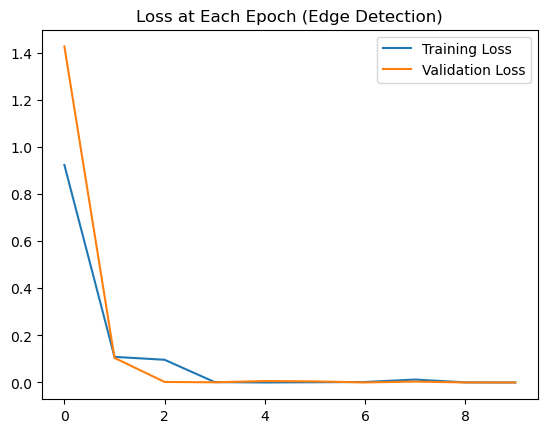

In [44]:
# plot of train and validation losses of CNN
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Each Epoch (Edge Detection)")
plt.legend()
plt.show()

In [45]:
# accuracy, precision, recall, F1 scores
print(f"CNN Model (Edge Detection)\n{classification_report(y_test_int2, predicted.tolist(), target_names=unique_labels)}")

CNN Model (Edge Detection)
                  precision    recall  f1-score   support

    glioma_tumor       0.77      0.78      0.78       192
meningioma_tumor       0.75      0.73      0.74       195
 pituitary_tumor       0.93      0.95      0.94       172
        no_tumor       0.83      0.81      0.82        94

        accuracy                           0.81       653
       macro avg       0.82      0.82      0.82       653
    weighted avg       0.81      0.81      0.81       653



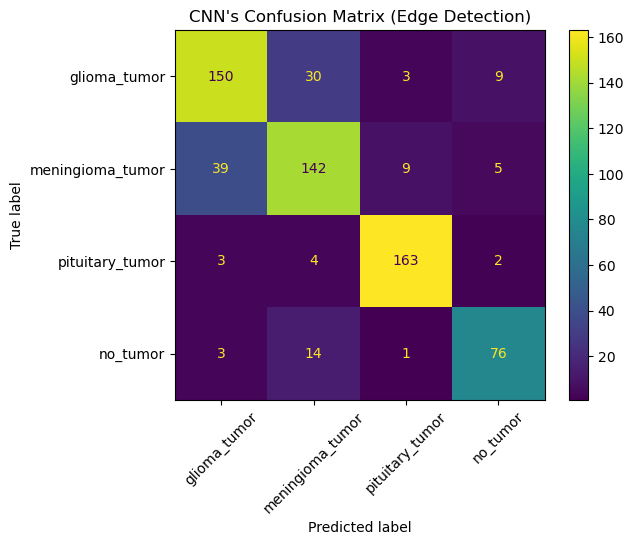

In [46]:
c_matrix = confusion_matrix(y_test_int2, predicted.tolist(), labels=list(set(y_test_int2)))
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=[int_to_label[integer] for integer in list(set(y_test_int2))])

disp.plot()
disp.ax_.set(title="CNN's Confusion Matrix (Edge Detection)")
plt.xticks(rotation=45)  # rotate x-axis labels

plt.show()

## k-Nearest Neighbors Model

In [47]:
np.random.seed(1) # for reproducibility

# KNN grid search
knn_params = {"n_neighbors": range(3, 30, 2)}
knn_grid_search = GridSearchCV(KNeighborsClassifier(weights="distance"), param_grid=knn_params, cv=cv).fit(X_train2.reshape(-1, 200**2), y_train_int2)
print(f"Optimal hyperparameters for KNN: {knn_grid_search.best_params_}\n")

# fit KNN model
knn = KNeighborsClassifier(**knn_grid_search.best_params_, weights="distance").fit(X_train2.reshape(-1, 200**2), y_train_int2)

Optimal hyperparameters for KNN: {'n_neighbors': 3}



In [48]:
# KNN predictions
knn_predictions = knn.predict(X_test2.reshape(-1, 200**2))

# accuracy, precision, recall, F1 scores
print(f"KNN Model (Edge Detection)\n{classification_report(y_test_int2, knn_predictions, target_names=unique_labels)}")

KNN Model (Edge Detection)
                  precision    recall  f1-score   support

    glioma_tumor       0.79      0.76      0.78       192
meningioma_tumor       0.73      0.77      0.75       195
 pituitary_tumor       0.85      0.97      0.90       172
        no_tumor       0.81      0.57      0.67        94

        accuracy                           0.79       653
       macro avg       0.80      0.77      0.78       653
    weighted avg       0.79      0.79      0.79       653



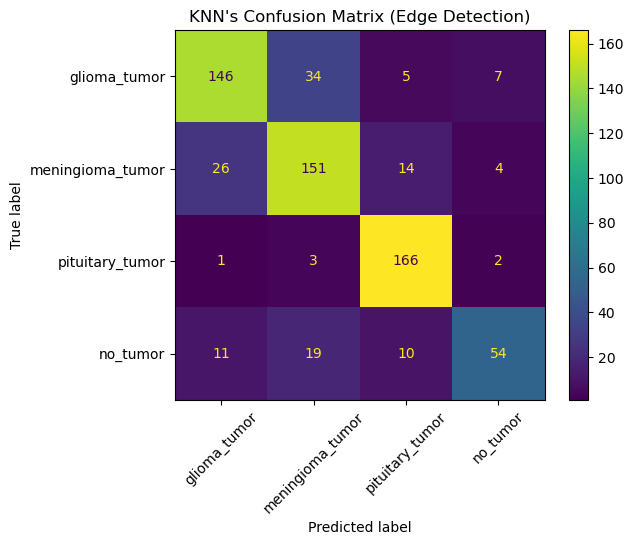

In [49]:
c_matrix = confusion_matrix(y_test_int2, knn_predictions, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=[int_to_label[integer] for integer in knn.classes_])

disp.plot()
disp.ax_.set(title="KNN's Confusion Matrix (Edge Detection)")
plt.xticks(rotation=45)  # rotate x-axis labels

plt.show()

## Random Forest Model

In [50]:
np.random.seed(1) # for reproducibility

# fit random forest model
rforest = RandomForestClassifier(n_estimators=400, warm_start=True).fit(X_train2.reshape(-1, 200**2), y_train_int2)


In [51]:
# random forest predictions
rforest_predictions = rforest.predict(X_test2.reshape(-1, 200**2))

# accuracy, precision, recall, F1 scores
print(f"Random Forest Model (Edge Detection)\n{classification_report(y_test_int2, rforest_predictions, target_names=unique_labels)}")


Random Forest Model (Edge Detection)
                  precision    recall  f1-score   support

    glioma_tumor       0.77      0.76      0.76       192
meningioma_tumor       0.71      0.67      0.69       195
 pituitary_tumor       0.79      0.97      0.87       172
        no_tumor       0.85      0.64      0.73        94

        accuracy                           0.77       653
       macro avg       0.78      0.76      0.76       653
    weighted avg       0.77      0.77      0.76       653



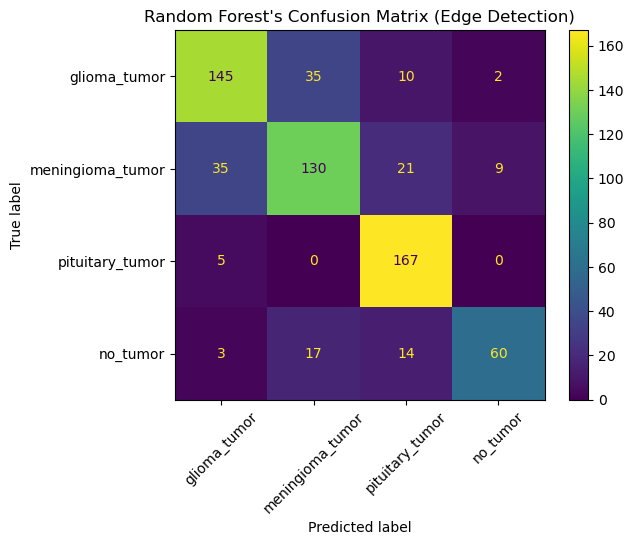

In [52]:
c_matrix = confusion_matrix(y_test_int2, rforest_predictions, labels=rforest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=[int_to_label[integer] for integer in rforest.classes_])

disp.plot()
disp.ax_.set(title="Random Forest's Confusion Matrix (Edge Detection)")
plt.xticks(rotation=45)  # rotate x-axis labels

plt.show()

## Support Vector Machine Model

In [53]:
np.random.seed(1) # for reproducibility

# fit SVM model
svm = SVC(kernel="poly", decision_function_shape="ovo").fit(X_train2.reshape(-1, 200**2), y_train_int2)


In [54]:
# SVM predictions
svm_predictions = svm.predict(X_test2.reshape(-1, 200**2))

# accuracy, precision, recall, F1 scores
print(f"SVM Model (Edge Detection)\n{classification_report(y_test_int2, svm_predictions, target_names=unique_labels)}")


SVM Model (Edge Detection)
                  precision    recall  f1-score   support

    glioma_tumor       0.76      0.81      0.78       192
meningioma_tumor       0.76      0.74      0.75       195
 pituitary_tumor       0.90      0.97      0.93       172
        no_tumor       0.88      0.69      0.77        94

        accuracy                           0.81       653
       macro avg       0.82      0.80      0.81       653
    weighted avg       0.81      0.81      0.81       653



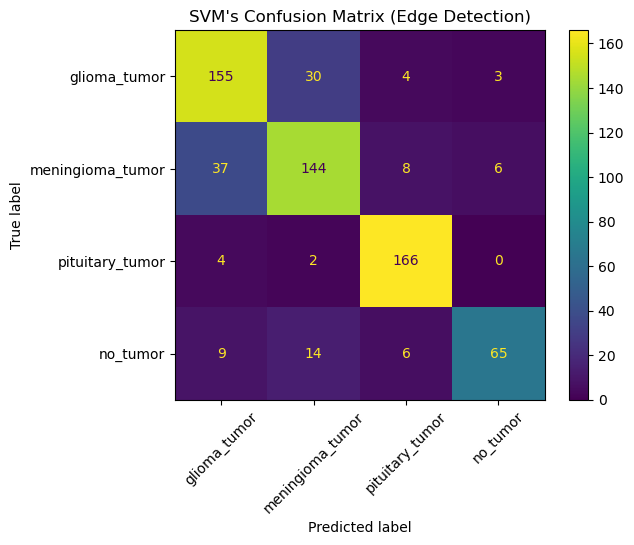

In [55]:
c_matrix = confusion_matrix(y_test_int2, svm_predictions, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=[int_to_label[integer] for integer in svm.classes_])

disp.plot()
disp.ax_.set(title="SVM's Confusion Matrix (Edge Detection)")
plt.xticks(rotation=45)  # rotate x-axis labels

plt.show()

## Fit Logistic Regression Model

In [56]:
np.random.seed(1) # for reproducibility

# fit logistic regression model
lreg = LogisticRegression(multi_class="multinomial").fit(X_train2.reshape(-1, 200**2), y_train_int2)

In [57]:
# logistic regression predictions
lreg_predictions = lreg.predict(X_test2.reshape(-1, 200**2))

# accuracy, precision, recall, F1 scores
print(f"Logistic Regression Model (Edge Detection)\n{classification_report(y_test_int2, lreg_predictions, target_names=unique_labels)}")


Logistic Regression Model (Edge Detection)
                  precision    recall  f1-score   support

    glioma_tumor       0.75      0.78      0.77       192
meningioma_tumor       0.75      0.71      0.73       195
 pituitary_tumor       0.92      0.99      0.96       172
        no_tumor       0.85      0.78      0.81        94

        accuracy                           0.81       653
       macro avg       0.82      0.81      0.82       653
    weighted avg       0.81      0.81      0.81       653



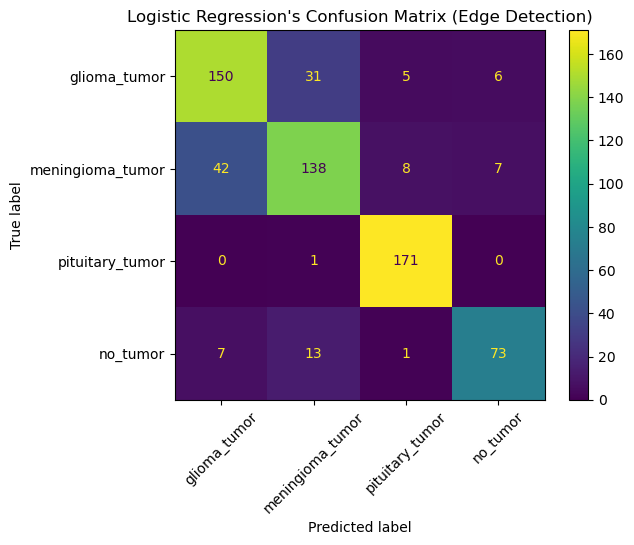

In [58]:
c_matrix = confusion_matrix(y_test_int2, lreg_predictions, labels=lreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=[int_to_label[integer] for integer in lreg.classes_])

disp.plot()
disp.ax_.set(title="Logistic Regression's Confusion Matrix (Edge Detection)")
plt.xticks(rotation=45)  # rotate x-axis labels

plt.show()

## Model Evaluation (Edge Detection)

This summary of evaluation metrics of each of the models is based on the macro average of precision, recall, and F1 score. Using the macro average makes each class of images weighted equally, since the goal is to decrease the bias towards the most frequent class.

| Model | Accuracy | Precision | Sensitivity/Recall | F1 Score |
| :-: | :-: | :-: | :-: | :-: |
| Convolutional Neural Network | 0.81 | 0.82 | 0.82 | 0.82 |
| k-Nearest Neighbors | 0.79 | 0.80 | 0.77 | 0.78 |
| Random Forest | 0.77 | 0.78 | 0.76 | 0.76 |
| Support Vector Machine | 0.81 | 0.82 | 0.80 | 0.81 |
| Logistic Regression | 0.81 | 0.82 | 0.81 | 0.82 |

The convolutional neural network performs the best overall in terms of three of the four metrics: precision, recall, and F1 score, with a score of 0.82 for them. It is tied with the support vector machine and logistic regression with an accuracy of 0.81. The logistic regression model performed as well as the neural network did in terms of accuracy, precision, and F1 score. But in terms of recall, it performs slightly inferior. Each model has a very similar precision, recall, and F1 score, indicating no bias towards predicting the most common class.

Interestingly, random forest performs the worst in all metrics. Ensemble models such as random forest typically have a superior accuracy compared to most other model types. Again, this problem is a multi-class classification problem. And so overall it still does not perform terribly. 

The support vector machine has the lowest chance of missing a tumor with a probability of $\frac{9}{90} = 10\%$. This is unfortunately still a little high for such a serious issue, so a radiologist would be advised to look further into an MRI scan if the SVM model does not detect a tumor using edge detection. It is however a lower probability than for the CNN model for the compressed MRI images.

# Conclusions

In conclusion, machine learning is an amazing tool for the medical field. Throughout this project, in attempt to reduce the need for expensive MRI equipment, a set of 3264 MRI images have been compressed from a size of 4000 pixels, to a size of 500 pixels (projected back to the 4000 pixel space) using principal component analysis. The compressed images are then refined using the Sobel operator for edge detection, in attempt to refine the images. Classifying the MRI images by tumor type, both the compressed and edge detected sets of MRI images are used to fit and test the following classification models: convolutional neural network, k-nearest neighbors, random forest, support vector machine, and logistic regression.

It was a bit of a surprise initially to see that using edge detection on the compressed MRI scans did not improve the performance of any of the classification models. The purpose of edge detection is to further define edges within an image with all other aspects of the image ignored. It is clear however that image compression led to less-defined edges within the image. Hence, critical edges that are defined by some tumors likely have been left out during edge detection. It also made the differences between the glioma and meningioma tumors less clear than without edge detection. One improvement that edge detection had however was missing a lower number of tumors with the SVM model.

Each of the models had a similar precision, recall, and F1 score. Thus, in this classification model of very imbalanced data, there was little bias towards predicting the most prevalent class, which is key in such problems. The overall accuracy in the best performing model (random forest of compressed MRI images) is also very good. One improvement that should be made in the future however is prioritizing a decrease in the probability of a model missing a tumor. This would be done by prioritizing an increase in recall, which has mostly been a little lower than precision in all models. The purpose of having a MRI done on a patient's head is to detect brain tumors, and missing a brain tumor can be detrimental to their health and wellbeing, especially if it is malignant.